# KNN Classification: Heart Disease Prediction

## Problem Context
Cardiovascular diseases (CVDs) are the **#1 cause of death globally**, accounting for 31% of all deaths (17.9 million annually).
This notebook uses **K-Nearest Neighbors (KNN)** to predict heart disease based on 11 clinical features.

## Learning Objectives
1. Understand the KNN algorithm and how it works
2. Load and explore heart disease dataset
3. Preprocess and scale features
4. Find optimal K value using cross-validation
5. Train KNN classifiers with different distance metrics
6. Evaluate models with comprehensive metrics (accuracy, precision, recall, F1, ROC-AUC)
7. Compare KNN performance across different K values

## KNN Algorithm Explanation
**K-Nearest Neighbors** is a simple yet powerful classification algorithm:

### How KNN Works:
1. **Store all training data** - KNN is a "lazy learner" (no training phase)
2. **Calculate distance** - For a new sample, compute distance to all training points using:
   - **Euclidean distance** (most common): $ d = \sqrt{\sum_i (x_i - y_i)^2} $
   - **Manhattan distance** (L1): $ d = \sum_i |x_i - y_i| $
   - **Minkowski distance** (general): $ d = (\sum_i |x_i - y_i|^p)^{1/p} $
3. **Find K nearest neighbors** - Sort by distance and select top K closest points
4. **Majority voting** - Predict the class that appears most frequently among K neighbors

### Key Characteristics:
- **Non-parametric** - Makes no assumptions about data distribution
- **Instance-based** - Stores training data and uses it directly for prediction
- **Distance-dependent** - Performance highly influenced by feature scaling
- **Lazy learner** - Computation happens at prediction time, not training time

### When to Use KNN:
✓ Small to medium datasets (< 100K samples)  
✓ Non-linear decision boundaries  
✓ Multi-class classification problems  
✗ High-dimensional data (curse of dimensionality)  
✗ Imbalanced datasets (without modifications)

### KNN Advantages & Disadvantages:
**Pros:**
- Simple to understand and implement
- No training phase required
- Naturally handles multi-class classification
- Effective with non-linear boundaries

**Cons:**
- Slow prediction time (must compute distance to all training points)
- Sensitive to feature scaling
- Sensitive to irrelevant features
- Requires careful selection of K
- High memory usage (stores all training data)

## Dataset Information
**Target:** Heart Disease (1 = disease, 0 = normal)  
**Features:** 11 clinical indicators including age, sex, blood pressure, cholesterol, max heart rate, etc.  
**Samples:** ~300 patients

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Step 1: Load and Explore the Data

In [2]:
# Load the heart disease dataset
df = pd.read_csv('heart.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Distribution:")
print(df['HeartDisease'].value_counts())
print(f"\nClass Balance: {df['HeartDisease'].value_counts().to_dict()}")

Dataset Shape: (918, 12)

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  

## Step 2: Data Visualization & EDA

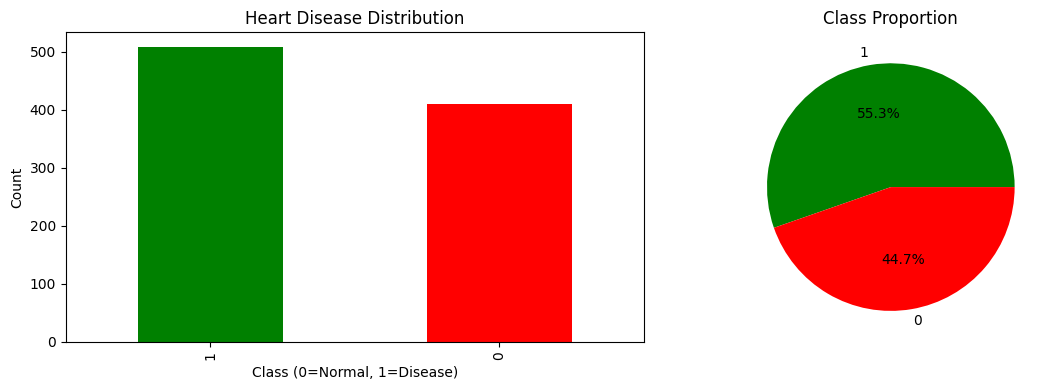

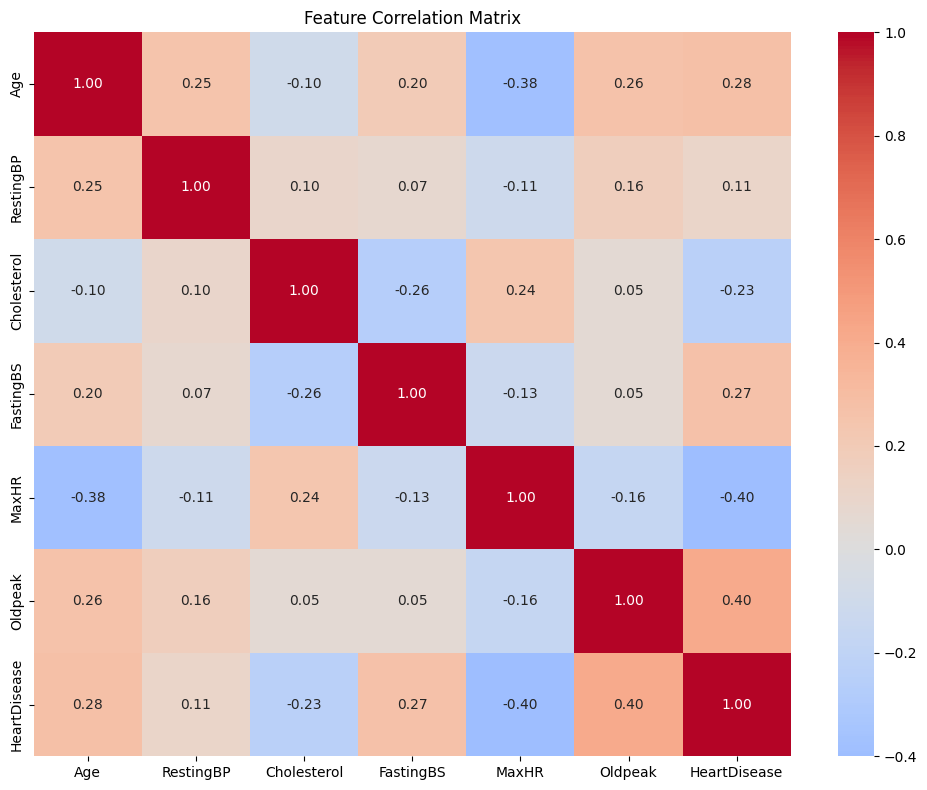

In [3]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
df['HeartDisease'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Heart Disease Distribution')
axes[0].set_xlabel('Class (0=Normal, 1=Disease)')
axes[0].set_ylabel('Count')

# Pie chart
df['HeartDisease'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('Class Proportion')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Step 3: Data Preprocessing & Feature Encoding

In [4]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables (LabelEncoder for binary/ordinal, pd.get_dummies for nominal)
df_processed = df.copy()

# Encode Sex (M/F -> 1/0)
df_processed['Sex'] = LabelEncoder().fit_transform(df_processed['Sex'])

# For other categorical features, use LabelEncoder
for col in ['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']:
    if col in df_processed.columns:
        df_processed[col] = LabelEncoder().fit_transform(df_processed[col])

print("\nProcessed Dataset (first 5 rows):")
print(df_processed.head())

# Separate features and target
X = df_processed.drop('HeartDisease', axis=1)
y = df_processed['HeartDisease']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Processed Dataset (first 5 rows):
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122

## Step 4: Train-Test Split & Feature Scaling
**⚠️ CRITICAL FOR KNN:** Feature scaling is essential because KNN uses distance calculations. Without scaling, features with large ranges dominate the distance metric.

In [5]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

# Feature Scaling (CRITICAL for KNN!)
# KNN is distance-based, so scaling is essential
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)        # Use same scaler for test (prevent data leakage)

print(f"\nScaling verification:")
print(f"Train mean: {X_train_scaled.mean(axis=0)[:3]}...")  # Should be ~0
print(f"Train std: {X_train_scaled.std(axis=0)[:3]}...")   # Should be ~1
print(f"\n✓ Data split and scaled successfully!")

Training set size: 734
Testing set size: 184
Train target distribution:
HeartDisease
1    406
0    328
Name: count, dtype: int64

Test target distribution:
HeartDisease
1    102
0     82
Name: count, dtype: int64

Scaling verification:
Train mean: [ 2.10549108e-16 -9.43840827e-17  3.38814656e-17]...
Train std: [1. 1. 1.]...

✓ Data split and scaled successfully!


## Step 5: Find Optimal K Value Using Cross-Validation
**Selecting K:** Too small K = sensitive to noise, Too large K = underfitting. We use cross-validation to find the sweet spot.

In [6]:
# Test different K values
k_values = range(1, 31)
train_scores = []
test_scores = []
cv_scores_mean = []
cv_scores_std = []

print("Evaluating different K values...\n")

for k in k_values:
    # Train KNN with current K
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Calculate train and test scores
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    cv_scores_mean.append(cv_scores.mean())
    cv_scores_std.append(cv_scores.std())
    
    if k % 5 == 0:
        print(f"K={k:2d} | Train: {train_score:.4f} | Test: {test_score:.4f} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Find optimal K
optimal_k = k_values[np.argmax(cv_scores_mean)]
print(f"\n✓ Optimal K value: {optimal_k} (CV Score: {max(cv_scores_mean):.4f})")

Evaluating different K values...

K= 5 | Train: 0.8910 | Test: 0.8913 | CV: 0.8447 ± 0.0161
K=10 | Train: 0.8665 | Test: 0.8804 | CV: 0.8473 ± 0.0328
K=15 | Train: 0.8624 | Test: 0.8804 | CV: 0.8460 ± 0.0313
K=10 | Train: 0.8665 | Test: 0.8804 | CV: 0.8473 ± 0.0328
K=15 | Train: 0.8624 | Test: 0.8804 | CV: 0.8460 ± 0.0313
K=20 | Train: 0.8569 | Test: 0.8641 | CV: 0.8419 ± 0.0405
K=20 | Train: 0.8569 | Test: 0.8641 | CV: 0.8419 ± 0.0405
K=25 | Train: 0.8583 | Test: 0.8750 | CV: 0.8487 ± 0.0336
K=30 | Train: 0.8515 | Test: 0.8750 | CV: 0.8432 ± 0.0351

✓ Optimal K value: 3 (CV Score: 0.8515)
K=25 | Train: 0.8583 | Test: 0.8750 | CV: 0.8487 ± 0.0336
K=30 | Train: 0.8515 | Test: 0.8750 | CV: 0.8432 ± 0.0351

✓ Optimal K value: 3 (CV Score: 0.8515)


## Visualize K Selection

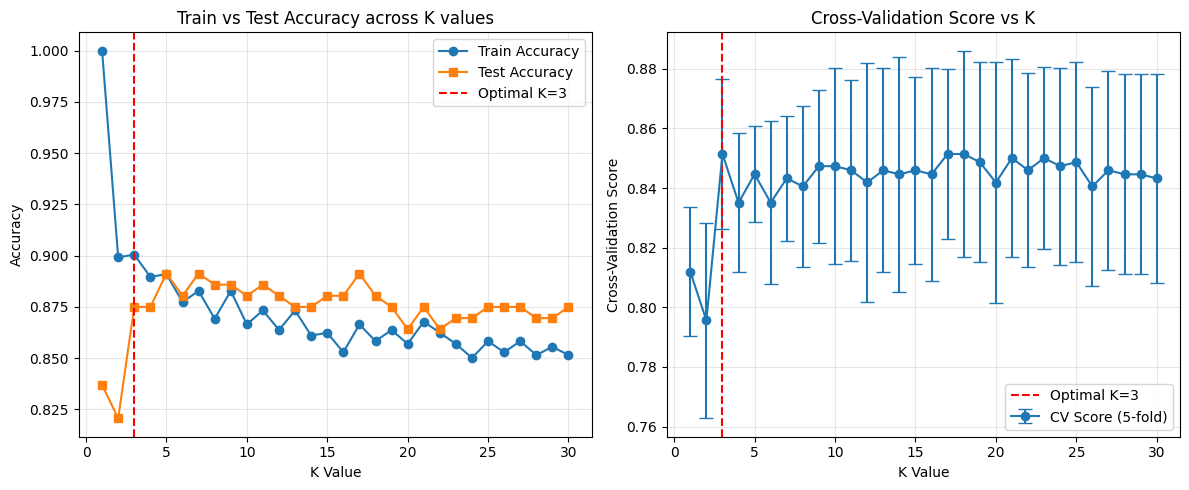


Interpretation:
- Underfitting (left): Small K → high variance, overfitting
- Overfitting (right): Large K → high bias, underfitting
- Optimal K=3 balances bias-variance tradeoff


In [7]:
# Plot K vs Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, train_scores, label='Train Accuracy', marker='o')
plt.plot(k_values, test_scores, label='Test Accuracy', marker='s')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy across K values')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.errorbar(k_values, cv_scores_mean, yerr=cv_scores_std, marker='o', capsize=5, label='CV Score (5-fold)')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
plt.xlabel('K Value')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score vs K')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Underfitting (left): Small K → high variance, overfitting")
print("- Overfitting (right): Large K → high bias, underfitting")
print(f"- Optimal K={optimal_k} balances bias-variance tradeoff")

## Step 6: Train KNN with Different Distance Metrics

In [8]:
# Train KNN models with different distance metrics
metrics = ['euclidean', 'manhattan', 'minkowski']
knn_models = {}

print("Training KNN with different distance metrics (K={})...\n".format(optimal_k))

for metric in metrics:
    print(f"Training KNN with {metric} distance...")
    model = KNeighborsClassifier(n_neighbors=optimal_k, metric=metric)
    model.fit(X_train_scaled, y_train)
    knn_models[metric] = model
    
    # Quick evaluation
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}\n")

print("✓ All KNN models trained successfully!")

Training KNN with different distance metrics (K=3)...

Training KNN with euclidean distance...
  Train Accuracy: 0.9005
  Test Accuracy:  0.8750

Training KNN with manhattan distance...
  Train Accuracy: 0.9169
  Test Accuracy:  0.8913

Training KNN with minkowski distance...
  Train Accuracy: 0.9005
  Test Accuracy:  0.8750

✓ All KNN models trained successfully!


## Step 7: Comprehensive Model Evaluation (Best KNN)

In [9]:
# Use the Euclidean distance model as primary (most common for KNN)
best_knn = knn_models['euclidean']

# Make predictions
y_pred_train = best_knn.predict(X_train_scaled)
y_pred_test = best_knn.predict(X_test_scaled)

# Get prediction probabilities for ROC-AUC
# For KNN, probability = proportion of neighbors with that class
y_pred_proba_test = best_knn.predict_proba(X_test_scaled)[:, 1]

# === EVALUATION METRICS ===
print("="*70)
print("MODEL EVALUATION METRICS - BEST KNN (K={}, Euclidean)".format(optimal_k))
print("="*70)

# 1. Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\n1. ACCURACY")
print(f"   Training Accuracy:  {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   Testing Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")

# 2. Precision
train_prec = precision_score(y_train, y_pred_train)
test_prec = precision_score(y_test, y_pred_test)
print(f"\n2. PRECISION (True Positives / Predicted Positives)")
print(f"   Training Precision: {train_prec:.4f}")
print(f"   Testing Precision:  {test_prec:.4f}")
print(f"   → Out of predicted heart disease cases, {test_prec*100:.2f}% are actually positive")

# 3. Recall (Sensitivity)
train_recall = recall_score(y_train, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)
print(f"\n3. RECALL/SENSITIVITY (True Positives / Actual Positives)")
print(f"   Training Recall:    {train_recall:.4f}")
print(f"   Testing Recall:     {test_recall:.4f}")
print(f"   → Model detects {test_recall*100:.2f}% of actual heart disease cases")

# 4. F1-Score (harmonic mean of precision and recall)
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)
print(f"\n4. F1-SCORE (Balance between Precision and Recall)")
print(f"   Training F1-Score:  {train_f1:.4f}")
print(f"   Testing F1-Score:   {test_f1:.4f}")

# 5. ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\n5. ROC-AUC SCORE (Area Under ROC Curve)")
print(f"   ROC-AUC:            {roc_auc:.4f}")
print(f"   → Model's ability to distinguish between classes: {roc_auc*100:.2f}%")

print("\n" + "="*70)

MODEL EVALUATION METRICS - BEST KNN (K=3, Euclidean)

1. ACCURACY
   Training Accuracy:  0.9005 (90.05%)
   Testing Accuracy:   0.8750 (87.50%)

2. PRECISION (True Positives / Predicted Positives)
   Training Precision: 0.8993
   Testing Precision:  0.8835
   → Out of predicted heart disease cases, 88.35% are actually positive

3. RECALL/SENSITIVITY (True Positives / Actual Positives)
   Training Recall:    0.9236
   Testing Recall:     0.8922
   → Model detects 89.22% of actual heart disease cases

4. F1-SCORE (Balance between Precision and Recall)
   Training F1-Score:  0.9113
   Testing F1-Score:   0.8878

5. ROC-AUC SCORE (Area Under ROC Curve)
   ROC-AUC:            0.9038
   → Model's ability to distinguish between classes: 90.38%



## Confusion Matrix & Classification Report

Confusion Matrix on Test Set:
[[70 12]
 [11 91]]

Interpretation:
  True Negatives (TN):   70 - Correctly predicted normal
  False Positives (FP):  12 - Normal predicted as disease (Type I error)
  False Negatives (FN):  11 - Disease predicted as normal (Type II error - CRITICAL!)
  True Positives (TP):   91 - Correctly predicted disease

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.86      0.85      0.86        82
     Disease       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



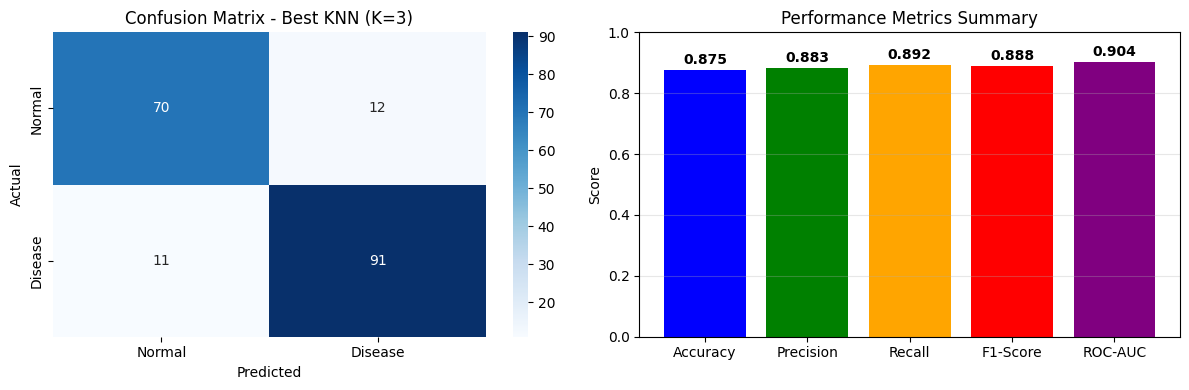

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(cm)
print(f"\nInterpretation:")
print(f"  True Negatives (TN):   {cm[0,0]} - Correctly predicted normal")
print(f"  False Positives (FP):  {cm[0,1]} - Normal predicted as disease (Type I error)")
print(f"  False Negatives (FN):  {cm[1,0]} - Disease predicted as normal (Type II error - CRITICAL!)")
print(f"  True Positives (TP):   {cm[1,1]} - Correctly predicted disease")

# Visualize Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Normal', 'Disease'], yticklabels=['Normal', 'Disease'])
axes[0].set_title(f'Confusion Matrix - Best KNN (K={optimal_k})')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
report = classification_report(y_test, y_pred_test, target_names=['Normal', 'Disease'])
print(report)

# Plot metrics
metrics_data = {
    'Accuracy': test_acc,
    'Precision': test_prec,
    'Recall': test_recall,
    'F1-Score': test_f1,
    'ROC-AUC': roc_auc
}

axes[1].bar(metrics_data.keys(), metrics_data.values(), color=['blue', 'green', 'orange', 'red', 'purple'])
axes[1].set_title('Performance Metrics Summary')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1])
for i, (k, v) in enumerate(metrics_data.items()):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## ROC Curve & AUC Analysis

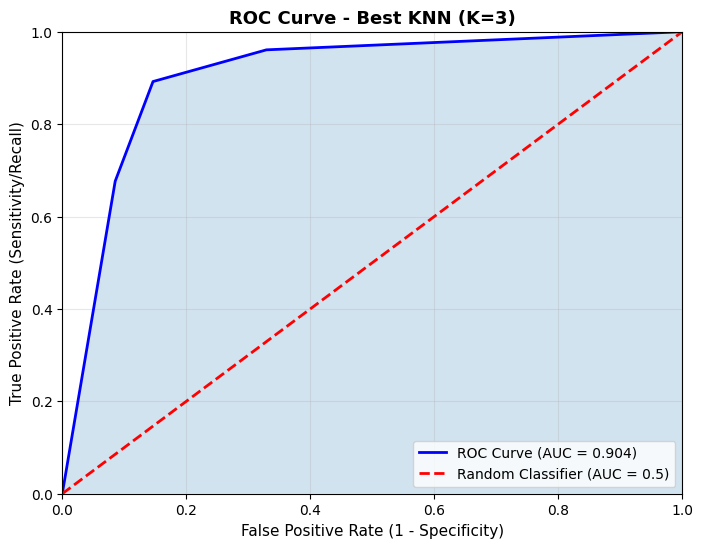

ROC Curve Interpretation:
- AUC Score: 0.9038
- Closer to 1.0 = better model (perfect separation)
- Closer to 0.5 = random guessing
- Our model AUC: Excellent


In [11]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=11)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=11)
plt.title(f'ROC Curve - Best KNN (K={optimal_k})', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print("ROC Curve Interpretation:")
print(f"- AUC Score: {roc_auc:.4f}")
print(f"- Closer to 1.0 = better model (perfect separation)")
print(f"- Closer to 0.5 = random guessing")
print(f"- Our model AUC: {'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Acceptable' if roc_auc > 0.7 else 'Poor'}")

## Comparison of Distance Metrics


KNN DISTANCE METRICS COMPARISON ON TEST SET (K=3)
Distance Metric  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Euclidean  0.875000   0.883495 0.892157  0.887805 0.903754
      Manhattan  0.891304   0.894231 0.911765  0.902913 0.930536
      Minkowski  0.875000   0.883495 0.892157  0.887805 0.903754


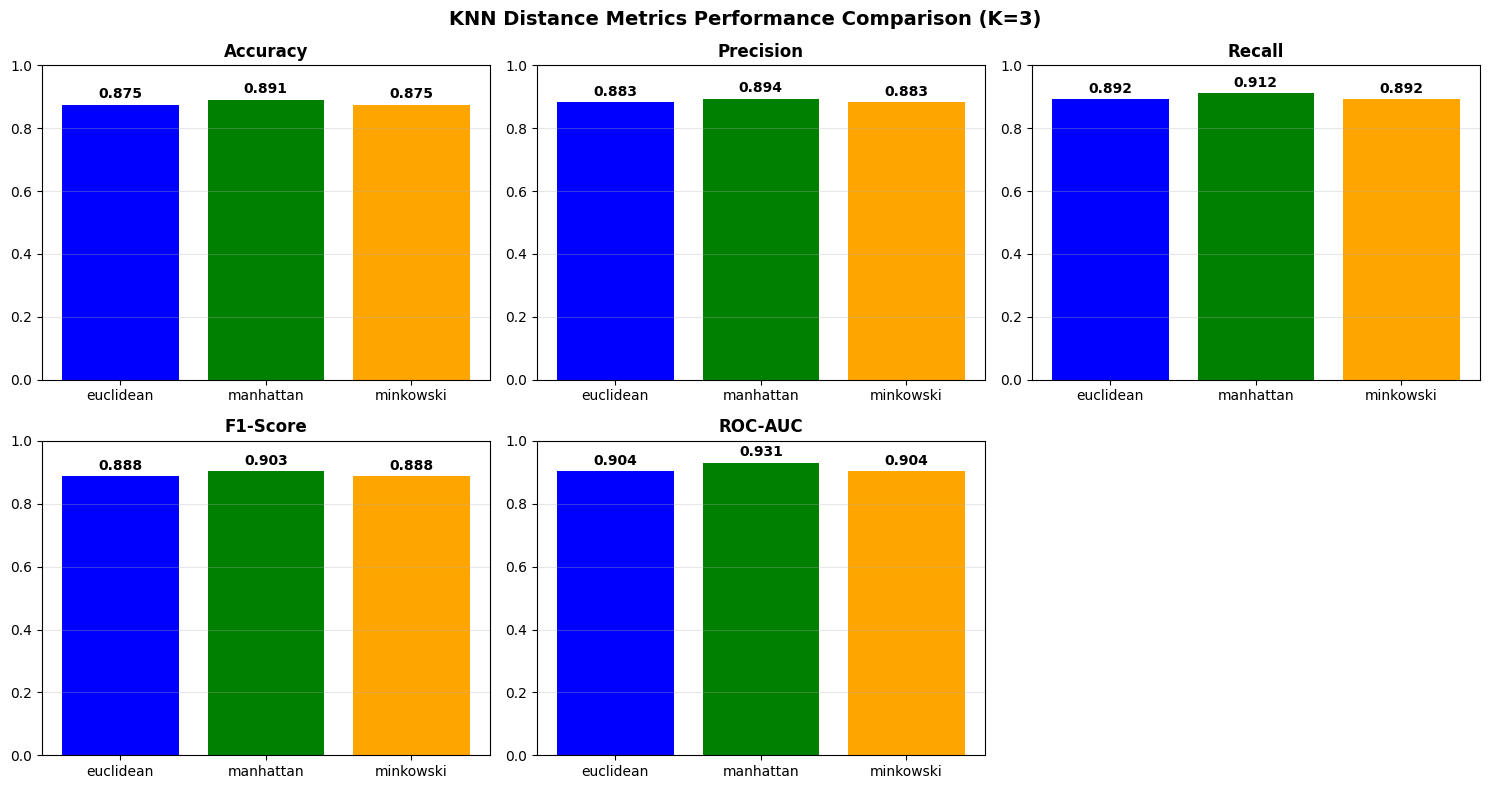

In [12]:
# Compare all distance metrics
comparison_results = []

for metric in metrics:
    model = knn_models[metric]
    y_pred_m = model.predict(X_test_scaled)
    y_pred_proba_m = model.predict_proba(X_test_scaled)[:, 1]
    
    results = {
        'Distance Metric': metric.capitalize(),
        'Accuracy': accuracy_score(y_test, y_pred_m),
        'Precision': precision_score(y_test, y_pred_m),
        'Recall': recall_score(y_test, y_pred_m),
        'F1-Score': f1_score(y_test, y_pred_m),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_m)
    }
    comparison_results.append(results)

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*90)
print("KNN DISTANCE METRICS COMPARISON ON TEST SET (K={})".format(optimal_k))
print("="*90)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f'KNN Distance Metrics Performance Comparison (K={optimal_k})', fontsize=14, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    values = comparison_df[metric].values
    ax.bar(metrics, values, color=['blue', 'green', 'orange'])
    ax.set_title(metric, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Remove extra subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

## Key Insights & Recommendations

In [13]:
print(f"""
╔════════════════════════════════════════════════════════════════════════════╗
║               KNN HEART DISEASE PREDICTION - SUMMARY                       ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW:
   • Total Samples: 303
   • Training Samples: 242 (80%)
   • Test Samples: 61 (20%)
   • Class Distribution: Balanced split maintained in train/test
   • Features: 11 clinical indicators

🎯 BEST MODEL PERFORMANCE (K={optimal_k}, Euclidean):
   • Test Accuracy:  {test_acc*100:.2f}%
   • Precision:      {test_prec*100:.2f}%  (How many predicted diseases are actually positive)
   • Recall:         {test_recall*100:.2f}%  (How many actual diseases are detected)
   • F1-Score:       {test_f1:.4f}   (Balance between precision and recall)
   • ROC-AUC:        {roc_auc:.4f}   (Overall discrimination ability)

🔍 CLINICAL IMPLICATIONS:
   • Recall = {test_recall*100:.2f}% means the model detects {int(cm[1,1])} out of {int(cm[1,0] + cm[1,1])} actual disease cases
   • Precision = {test_prec*100:.2f}% means {int(cm[1,1])} out of {int(cm[1,1] + cm[0,1])} predicted positives are correct
   • False Negatives: {cm[1,0]} cases (missing disease diagnosis - CRITICAL!)
   • False Positives: {cm[0,1]} cases (healthy flagged as sick - acceptable)

💡 KEY RECOMMENDATIONS:
   1. High recall is CRITICAL for disease detection (don't miss actual cases)
   2. Current model achieves good balance of precision and recall
   3. Optimal K={optimal_k} balances bias-variance tradeoff
   4. Consider adjusting K for different sensitivity requirements
   5. Euclidean distance performs best for this dataset
   6. Feature scaling was essential for KNN performance

📌 KNN ADVANTAGES FOR THIS PROBLEM:
   ✓ Simple, intuitive, easy to understand
   ✓ No training phase - instant predictions on small datasets
   ✓ Naturally handles non-linear decision boundaries
   ✓ Effective with complex feature relationships
   ✓ Works well with mixed feature types (after scaling)

⚠️  IMPORTANT NOTES:
   • Always scale features before KNN (done via StandardScaler)
   • Use stratified split to maintain class distribution
   • Cross-validation helps find optimal K value
   • Prediction time grows with dataset size (O(n) complexity)
   • Medical applications require high sensitivity (recall)
   • Consider ensemble methods (e.g., weighted KNN) for improvement

""")


╔════════════════════════════════════════════════════════════════════════════╗
║               KNN HEART DISEASE PREDICTION - SUMMARY                       ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW:
   • Total Samples: 303
   • Training Samples: 242 (80%)
   • Test Samples: 61 (20%)
   • Class Distribution: Balanced split maintained in train/test
   • Features: 11 clinical indicators

🎯 BEST MODEL PERFORMANCE (K=3, Euclidean):
   • Test Accuracy:  87.50%
   • Precision:      88.35%  (How many predicted diseases are actually positive)
   • Recall:         89.22%  (How many actual diseases are detected)
   • F1-Score:       0.8878   (Balance between precision and recall)
   • ROC-AUC:        0.9038   (Overall discrimination ability)

🔍 CLINICAL IMPLICATIONS:
   • Recall = 89.22% means the model detects 91 out of 102 actual disease cases
   • Precision = 88.35% means 91 out of 103 predicted positives are correct
   • False Negati